## For Colab

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Module Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import random
from tqdm import tqdm
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import glob
import itertools
import pickle
import re
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
!pip install rouge-score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constants
- remember to point to the right dataset

In [ ]:
drive_prefix = '/content/drive/MyDrive/ese546/'
PATH_TRAIN_X = drive_prefix + 'cnndm/train.txt.src'
PATH_TRAIN_Y = drive_prefix + 'cnndm/train.txt.tgt.tagged'

# PATH_TRAIN_X = drive_prefix + 'cnndm/small.src'
# PATH_TRAIN_Y = drive_prefix + 'cnndm/small.tagged'

# PATH_VAL_X = drive_prefix + 'cnndm/val.txt.src'
# PATH_VAL_Y = drive_prefix + 'cnndm/val.txt.tgt.tagged'

# CHANGE THIS AFTER
# PATH_TRAIN_X = drive_prefix + 'cnndm/test.txt.src'
# PATH_TRAIN_Y = drive_prefix + 'cnndm/test.txt.tgt.tagged'

STOP_WORDS = set()
EMB_SIZE = 300
GLOVE_EMB = drive_prefix + f'glove.6B.{EMB_SIZE}d.txt'
BATCH_SIZE = 32
NUM_EVAL_BATCHES = 4
NUM_HEADS = 10
DROPOUT_RATE = 0.2

START_CHAR = 'starttoken'
END_CHAR = 'endtoken'
PAD_CHAR = 'padtoken'

MAX_ARTICLE_LEN = 300 # the article can have at most 300 tokens
MAX_LABEL_LEN = 40 # labels can have at most 100 tokens

# NN Hyper-parameters
E_HIDDEN_DIM = 512
D_HIDDEN_DIM = 512
KEY_DIM = 64
VALUE_DIM = 64
LR = 1e-3

EP = 100000
PRINT_EVERY_EP = 200
SAVE_MODEL_EVERY_EP = 10000
FORCE_CREATE_DICT = True # force to recreate the word features from scratch, but doesn't recreate the embedding dict, since it doesn't change


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


## Helper Functions

In [ ]:
def create_word_vec(input_text, prefix='train'):
    word_idx_dict = {} # { word : the index of that word in the dictionary}
    idx_word_dict = {} # { index of word : word }
    
    # 1. Create mapping between words and the corresponding embedding values
    embed_file_path = drive_prefix + f'{EMB_SIZE}d_embed_dict'
    if os.path.exists(embed_file_path):
        print('Embedding dictionary exists, loading from file...')
        embedding_dict = pickle.load(open(embed_file_path, 'rb'))
    else:
        embedding_dict = {} 
        
        for line in glove:
            tokens = line.split()
            embedding_dict[tokens[0]] = np.array(tokens[1:], dtype='float32')
        pickle.dump(embedding_dict, open(embed_file_path, 'wb'))
        print('Saved embedding dictionary')

    # 2. Tokenize the input_text and labels
    if os.path.exists(drive_prefix + f'{prefix}_word_idx_dict') and not FORCE_CREATE_DICT:
        print('Word-to-index dictionary exists, loading from file...')
        word_idx_dict = pickle.load(open(drive_prefix + f'{prefix}_word_idx_dict', 'rb'))
    if os.path.exists(drive_prefix + f'{prefix}_idx_word_dict') and not FORCE_CREATE_DICT:
        print('Index-to-word dictionary exists, loading from file...')
        idx_word_dict = pickle.load(open(drive_prefix + f'{prefix}_idx_word_dict', 'rb'))
    else:
        unique_tokens = set([])
        for text, label in input_text:
            unique_tokens = unique_tokens.union(word_tokenize(text))
            unique_tokens = unique_tokens.union(word_tokenize(label))        

        for token in unique_tokens:
            word_idx_dict[token] = len(word_idx_dict)
                
        # 2.1 Add in the special tokens to the dictionary, note that the START_CHAR and END_CHAR have been added
        # during the preprocessing stage
        word_idx_dict[PAD_CHAR] = len(word_idx_dict)
        
        idx_word_dict = dict(zip(word_idx_dict.values(), word_idx_dict.keys()))
    
    # 3. Build the word vector for all the words in our dictionary
    if os.path.exists(drive_prefix + f'{prefix}_word_vector') and not FORCE_CREATE_DICT:
        print('Word Vector exists, loading from file...')
        word_vector = pickle.load(open(drive_prefix + f'{prefix}_word_vector', 'rb'))
    else:
        word_vector = []
        for idx, token in idx_word_dict.items():            
            if token in embedding_dict:
                word_vector.append(embedding_dict[token])
            # Append the special tokens to the word vector and assign random values
            elif token in [START_CHAR, END_CHAR, PAD_CHAR]:
                word_vector.append(np.random.normal(0, 1, EMB_SIZE))
            # if the token doesn't have an embedding, we set to 0
            else:
                word_vector.append(np.zeros([EMB_SIZE]))
    
    ## Save the dictionaries
    pickle.dump(word_idx_dict, open(drive_prefix + f'{prefix}_word_idx_dict', 'wb'))
    pickle.dump(idx_word_dict, open(drive_prefix + f'{prefix}_idx_word_dict', 'wb'))
    pickle.dump(word_vector, open(drive_prefix + f'{prefix}_word_vector', 'wb'))

    # The index in worvalue_dimec corresponds to the article index in the original X_Train array
    return np.array(word_vector), word_idx_dict, idx_word_dict

def sentence_to_idx(sentence, word_to_idx):
    text, label = sentence
    text_tokens = [word_to_idx[token] for token in word_tokenize(text)]
    label_tokens = [word_to_idx[token] for token in word_tokenize(label)]
    return np.array(text_tokens).astype(int), np.array(label_tokens).astype(int)

def decontracted(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text) 
    return text

def _process(text):
    text = decontracted(text)
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub('<[^>]*>', '', text)
    return text

def pre_process(articles, labels):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for i in tqdm(range(len(articles))):
        sent = articles[i]
        label = labels[i]

        sent = _process(sent)
        label = _process(label)        
        
        sent = sent.lower().strip().split()
        label = label.lower().strip().split()
        
        # trim longer items and ignore shorter ones
        if len(sent) < MAX_ARTICLE_LEN or len(label) < MAX_LABEL_LEN:
            continue
        
        sent = ' '.join(sent[:MAX_ARTICLE_LEN])
        label = ' '.join(label[:MAX_LABEL_LEN])
        label = f"{START_CHAR} {label} {END_CHAR}"
        preprocessed_text.append([sent, label])
    return preprocessed_text

def get_batch(data):
    while True:
        for i in range(int((data.shape[0] - BATCH_SIZE) / BATCH_SIZE)):
            yield data[i * BATCH_SIZE: i * BATCH_SIZE + BATCH_SIZE]

def patch_trg(trg):
    # Need to understand
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def plot(train_loss, val_loss):
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Val')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Read Data

In [ ]:
with open(PATH_TRAIN_X, 'r', encoding='utf-8') as f:
    X = f.readlines()[:100000]
    
with open(PATH_TRAIN_Y, 'r', encoding='utf-8') as f:
    Y = f.readlines()[:100000]
    
with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
    glove = f.readlines() 

X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y, test_size=0.3, shuffle=True)

## Features

In [ ]:
def get_features(processed_data, prefix):
    # note that the prefix variable is only used for naming dictionaries that are 
    # saved to the disk
    print(f'\nTotal # of stories: {len(processed_data)}')
    word_vector, word_idx_dict, idx_word_dict = create_word_vec(processed_data, prefix=prefix)
    print(f'Word Vector Shape: {word_vector.shape}')
    assert word_vector.shape == (len(idx_word_dict.keys()), EMB_SIZE)
 
    return word_vector, word_idx_dict, idx_word_dict

# USING THE CELL BELOW TO SPEED THINGS UP
# # Full
full_processed_data = pre_process(X, Y)
full_word_vector, full_word_idx_dict, full_idx_word_dict = get_features(full_processed_data, prefix='train')

# Training
train_processed_data = pre_process(X_Train, Y_Train)
# convert sentences into indicies corresponding to the word vector indices
train_data_indices = np.array([sentence_to_idx(sentence, full_word_idx_dict) for sentence in train_processed_data])   

# Validation
val_processed_data = pre_process(X_Val, Y_Val)
val_data_indices = np.array([sentence_to_idx(sentence, full_word_idx_dict) for sentence in val_processed_data])   

100%|██████████| 100000/100000 [01:19<00:00, 1263.35it/s]



Total # of stories: 48049
Embedding dictionary exists, loading from file...


  0%|          | 132/70000 [00:00<00:53, 1316.45it/s]

Word Vector Shape: (155450, 300)


100%|██████████| 30000/30000 [00:23<00:00, 1255.57it/s]


In [ ]:
if os.path.exists(drive_prefix + 'full_processed_data'):
    print('full_processed_data exists, loading from file...')
    full_processed_data = pickle.load(open(drive_prefix + 'full_processed_data', 'rb'))
else:
    full_processed_data = pre_process(X, Y)
    full_word_vector, full_word_idx_dict, full_idx_word_dict = get_features(full_processed_data, prefix='train')

if os.path.exists(drive_prefix + 'train_processed_data'):
    print('train_processed_data exists, loading from file...')
    train_processed_data = pickle.load(open(drive_prefix + 'train_processed_data', 'rb'))
else:
    train_data_indices = np.array([sentence_to_idx(sentence, full_word_idx_dict) for sentence in train_processed_data])   

if os.path.exists(drive_prefix + 'val_processed_data'):
    print('val_processed_data exists, loading from file...')
    val_processed_data = pickle.load(open(drive_prefix + 'val_processed_data', 'rb'))
else:
    val_processed_data = pre_process(X, Y)
    val_data_indices = np.array([sentence_to_idx(sentence, full_word_idx_dict) for sentence in val_processed_data])   

100%|██████████| 100000/100000 [01:18<00:00, 1266.71it/s]



Total # of stories: 48049
Embedding dictionary exists, loading from file...
Word Vector Shape: (155450, 300)


100%|██████████| 100000/100000 [01:17<00:00, 1293.99it/s]


In [ ]:
## Using this to speed things up
def dump(data, name):
    pickle.dump(data, open(drive_prefix + name, 'wb'))
    
dump(full_processed_data, 'full_processed_data')
dump(train_processed_data, 'train_processed_data')
dump(train_data_indices, 'train_data_indices')
dump(val_processed_data, 'val_processed_data')
dump(val_data_indices, 'val_data_indices')

In [ ]:
val_data_indices.shape

(48049, 2)

## Model

In [ ]:
# Create the embedding layer weights based on the pre-trained word vector
def create_pretrained_emb_layer(word_vector):
    # vocab_size, embed_dim = word_vector.shape
    embed_layer = nn.Embedding.from_pretrained(torch.tensor(word_vector).float(), freeze=False)    
    return embed_layer

def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

class PositionEmbedding(nn.Module):
    def __init__(self, dropout=DROPOUT_RATE, max_len=500):
        super(PositionEmbedding, self).__init__()

        self.dropout = nn.Dropout(dropout)
        self.pos_embedding = self.compute_pos_embedding(max_len)
    
    def compute_pos_embedding(self, max_len):

        pos = torch.arange(max_len).unsqueeze(1)
        index = torch.arange(EMB_SIZE).unsqueeze(0)
        angles = 1 / np.power(10000, (2 * (index // 2)) / np.float32(EMB_SIZE))
        
        pos_to_angle = pos * angles

        # apply sin to even indices in the array; 2i
        pos_to_angle[:, 0::2] = np.sin(pos_to_angle[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        pos_to_angle[:, 1::2] = np.cos(pos_to_angle[:, 1::2])

        # pos_embedding = pos_to_angle.unsqueeze(0).transpose(0, 1)
        pos_embedding = pos_to_angle.unsqueeze(0)

        return torch.FloatTensor(pos_embedding).to(device)

    def forward(self, x):
        x += self.pos_embedding[:, :x.shape[1]].clone().detach() # adding another feature to the word embedding
        return self.dropout(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_in, hidden_dim, dropout=DROPOUT_RATE):
        super(PositionwiseFeedForward, self).__init__()
        self.pos1 = nn.Linear(d_in, hidden_dim)
        self.pos2 = nn.Linear(hidden_dim, d_in)
        self.relu = nn.ReLU()
        self.normalization = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x
        out = self.pos1(x)
        out = self.relu(out)
        out = self.pos2(out)
        out = self.dropout(out)
        out += residual

        out = self.normalization(out)

        return out

class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, attn_dropout=DROPOUT_RATE):
        super(ScaledDotProductAttention, self).__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        attn = attn.masked_fill(mask == 0, -1e7)

        attn = self.softmax(attn)

        return torch.matmul(attn, v), self.dropout(attn)


class MultiHeadAttention(nn.Module):    
    def __init__(self, n_head, key_dim, value_dim, dropout=DROPOUT_RATE):
        super().__init__()

        self.n_head = n_head
        self.key_dim = key_dim
        self.value_dim = value_dim

        self.query_layer = nn.Linear(EMB_SIZE, n_head * key_dim, bias=False)
        self.key_layer = nn.Linear(EMB_SIZE, n_head * key_dim, bias=False)
        self.value_layer = nn.Linear(EMB_SIZE, n_head * value_dim, bias=False)
        self.fc = nn.Linear(n_head * value_dim, EMB_SIZE, bias=False)

        self.attention = ScaledDotProductAttention(temperature=key_dim ** 0.5).to(device)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(EMB_SIZE, eps=1e-6)


    def forward(self, q, k, v, attn_mask):

        key_dim, value_dim, n_head = self.key_dim, self.value_dim, self.n_head
        batch_size, q_len = q.size(0), q.size(1)
        k_len = k.size(1)
        v_len = v.size(1)

        residual = q

        q = self.query_layer(q).view(batch_size, q_len, n_head, key_dim)
        k = self.key_layer(k).view(batch_size, k_len, n_head, key_dim)
        v = self.value_layer(v).view(batch_size, v_len, n_head, value_dim)

        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        attn_mask = attn_mask.unsqueeze(1)

        q, attn = self.attention(q, k, v, mask=attn_mask)
        
        q = q.transpose(1, 2).contiguous().view(batch_size, q_len, -1)
        q = self.fc(q)
        q = self.dropout(q)
        q += residual

        q = self.layer_norm(q)

        return q, attn


class EncoderLayer(nn.Module):
    def __init__(self, d_inner, n_head, key_dim, value_dim, dropout=DROPOUT_RATE):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head=n_head, key_dim=key_dim, value_dim=value_dim, dropout=dropout).to(device)
        self.pos_ffn = PositionwiseFeedForward(EMB_SIZE, d_inner, dropout=dropout).to(device)

    def forward(self, enc_input, mask=None):
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, attn_mask=mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_inner, n_head, key_dim, value_dim, dropout=DROPOUT_RATE):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, key_dim, value_dim, dropout=dropout).to(device)
        self.enc_attn = MultiHeadAttention(n_head, key_dim, value_dim, dropout=dropout).to(device)        
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout).to(device)

    def forward(self, d_in, e_out,y_mask=None, x_mask=None):
        d_out, d_slf_attn = self.slf_attn(d_in, d_in, d_in, attn_mask=y_mask)
        d_out, d_e_attn = self.enc_attn(d_out, e_out, e_out, attn_mask=x_mask)
        d_out = self.pos_ffn(d_out)
        return d_out, d_slf_attn, d_e_attn


class Decoder(nn.Module):
    def __init__(self, n_layers, n_head, key_dim, value_dim,d_model, d_inner, dropout=DROPOUT_RATE):
        super(Decoder, self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([DecoderLayer(d_model, d_inner, n_head, key_dim, value_dim, dropout=dropout).to(device) for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, y, y_mask, e_out, x_mask):
        d_out = self.dropout(y)
        d_out = self.layer_norm(d_out)
        for dec_layer in self.layer_stack:
            d_out, dec_slf_attn, dec_enc_attn = dec_layer(d_out, e_out, y_mask=y_mask, x_mask=x_mask)

        return d_out,
    

class Encoder(nn.Module):
    def __init__(self, n_layers, n_head, key_dim, value_dim, dropout=DROPOUT_RATE):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([ EncoderLayer(E_HIDDEN_DIM, n_head, key_dim, value_dim, dropout=dropout).to(device) for _ in range(n_layers)])
        self.normalization = nn.LayerNorm(EMB_SIZE, eps=1e-6)

    def forward(self, x, x_mask):        
        e_out = self.dropout(x)
        e_out = self.normalization(e_out)
        
        for enc_layer in self.layers:
            e_out, enc_slf_attn = enc_layer(e_out, mask=x_mask)
            
        return e_out,

class Transformer(nn.Module):
    def __init__(self, num_heads, word_vector, word_idx_dict, idx_word_dict):
        super(Transformer, self).__init__()
        self.word_idx_dict = word_idx_dict
        self.pos_embedding = PositionEmbedding(max_len=MAX_ARTICLE_LEN, dropout=DROPOUT_RATE).to(device)
        self.word_embedding = create_pretrained_emb_layer(word_vector).to(device)

        self.encoder = Encoder(n_layers=3, n_head=num_heads, key_dim=KEY_DIM, value_dim=VALUE_DIM, dropout=DROPOUT_RATE).to(device)
        self.decoder = Decoder(n_layers=3, n_head=num_heads, key_dim=KEY_DIM, value_dim=VALUE_DIM, d_model=EMB_SIZE, d_inner=D_HIDDEN_DIM, dropout=DROPOUT_RATE).to(device)

        self.initial_probs = self.get_initial_probs(word_vector.shape[0], word_idx_dict[START_CHAR])
        
        self.fc_to_logits = nn.Linear(EMB_SIZE, len(idx_word_dict), bias=False)


    def mask_future_seq(self, seq):
        # Our attention is focused only allowed on the past sequence, so we mask
        sz_b, len_s = seq.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
        return subsequent_mask
    
    def get_initial_probs(self, vocab_size, initial_token_idx):
        probs = torch.zeros(1, vocab_size)
        probs[0, initial_token_idx] = 1
        return probs.float()

    def forward(self, x, y):
        x_mask = get_pad_mask(x, self.word_idx_dict[PAD_CHAR])
        y_mask = get_pad_mask(y, self.word_idx_dict[PAD_CHAR]) & self.mask_future_seq(y)
        
        x = self.word_embedding(x)
        x = self.pos_embedding(x)
        
        y = self.word_embedding(y)
        y = self.pos_embedding(y)
        
        
        # x = (batchsize, seqlen, embed dim)
        # y.shape = (batchsize, seqlen)
        
        # x_mask = (batchsize, 1, sequence length)
        # y_mask = (batchsize, sequence length, sequence length)
        # e_output = (batchsize, sequence length, embedding dimension)
        # d_output = (batchsize, sequence length, embedding dimension)
        
        e_out, *_ = self.encoder(x, x_mask) 
        d_out, *_ = self.decoder(y, y_mask, e_out, x_mask)        
        
        # self.fc_to_logits(dec_output) = (batchsize, seqlen, vocab len)
        logits = self.fc_to_logits(d_out) * 1 # no weight sharing
        
        return logits.view(-1, logits.size(2))

In [ ]:
# Reference: https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/fec78a687210851f055f792d45300d27cc60ae41/transformer/Optim.py#L4
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## Train Functions

In [ ]:
def _construct_summary(tokens, mapping):
    summary = []
    for token in tokens:
        token = token.item()
        if token in mapping and mapping[token] != PAD_CHAR:
            summary.append(mapping[token])
    return summary

def one_pass(x, y, gold, model, optim, criterion):
    optim.zero_grad()

    y_hat = model.forward(x, y) # (batchsize * seq len, vocab size)

    # NO LABEL SMOOTHING
    # loss = criterion(y_hat, gold)

    # LABEL SMOOTHING
    alpha = 0.1
    n_class = y_hat.size(1)

    y_hat_hot = torch.zeros_like(y_hat).scatter(1, gold.view(-1, 1), 1)
    y_hat_smooth = (1 - alpha) * y_hat_hot + (1 - y_hat_hot) * alpha / (n_class - 1) # y_ls = (1 - α) * y_hot + α / K
    log_prb = F.log_softmax(y_hat, dim=1)

    non_pad_mask = gold.ne(full_word_idx_dict[PAD_CHAR])
    loss = -(y_hat_smooth * log_prb).sum(dim=1)
    loss = loss.masked_select(non_pad_mask).sum()
    
    pred = y_hat.max(1)[1]    

    pred_summary = ' '.join(_construct_summary(pred, full_idx_word_dict)[1:-1])
    true_summary = ' '.join(_construct_summary(y.contiguous().view(-1), full_idx_word_dict)[1:-1])
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    
    # optim.step() #using lr-scheduler outside in train()
    optim.step_and_update_lr() # custom lr scheduler


    return loss, true_summary, pred_summary

## Evaluation One Pass
def one_pass_eval(model, criterion):
    model.eval()
    np.random.shuffle(val_data_indices)
    val_loader = get_batch(val_data_indices)
    eval_loss = 0
    eval_pass_pred = []
    eval_pass_true = []
    for _ in range(NUM_EVAL_BATCHES):
        data = val_loader.__next__()
        x, y = np.array(data[:, 0]), np.array(data[:, 1])
        x = torch.tensor(np.array([x[i] for i in range(len(x))])).long()
        y = torch.tensor(np.array([y[i] for i in range(len(y))])).long()
        
        x = x.to(device)
        y, gold = map(lambda x: x.to(device), patch_trg(y))
        y = y.to(device)

        with torch.no_grad():
            y_hat = model.forward(x, y) # (batchsize * seq len, vocab size)

            # loss = criterion(y_hat, gold)
            alpha = 0.1
            n_class = y_hat.size(1)

            y_hat_hot = torch.zeros_like(y_hat).scatter(1, gold.view(-1, 1), 1)
            y_hat_smooth = (1 - alpha) * y_hat_hot + (1 - y_hat_hot) * alpha / (n_class - 1) # y_ls = (1 - α) * y_hot + α / K
            log_prb = F.log_softmax(y_hat, dim=1)

            non_pad_mask = gold.ne(full_word_idx_dict[PAD_CHAR])
            loss = -(y_hat_smooth * log_prb).sum(dim=1)
            loss = loss.masked_select(non_pad_mask).sum()
            pred = y_hat.max(1)[1]
            temp_loss = loss.item()/BATCH_SIZE
            eval_loss += temp_loss
    
    model.train()
    eval_loss /=  NUM_EVAL_BATCHES
    return eval_loss

def train(model: Transformer, optim, criterion, model_name):
    print("Starting to train")
    model.train()
    ep_loss = []
    ep_eval_loss = []
    temp_loss = []
    eps = []
    for ep in range(1, EP + 1):
        np.random.shuffle(train_data_indices)
        train_loader = get_batch(train_data_indices)
        
        data = train_loader.__next__()
        x, y = np.array(data[:, 0]), np.array(data[:, 1])
        x = torch.tensor(np.array([x[i] for i in range(len(x))])).long()
        y = torch.tensor(np.array([y[i] for i in range(len(y))])).long()
        
        x = x.to(device)
        y, gold = map(lambda x: x.to(device), patch_trg(y))
        y = y.to(device)

        loss, true_summary, pred_summary = one_pass(x, y, gold, model, optim, criterion)
        
        temp_loss.append(loss.item() / BATCH_SIZE)
        
        if ep % PRINT_EVERY_EP == 0 and ep > 0:
            eval_loss = one_pass_eval(model, criterion)
            ep_loss.append(sum(temp_loss)/len(temp_loss))
            ep_eval_loss.append(eval_loss)
            eps.append(ep)
            temp_loss = []
            # print(ep, eval_loss, ep_loss[-1])
            # print(f'\nEP:{ep} | Train Loss: {np.array(ep_loss[-PRINT_EVERY_EP:]).mean()} | Val Loss: {np.array(eval_loss).mean()}')
            # print('Training')
            # print(f'True: {true_summary[:100]}')
            # print(f'Pred: {pred_summary[:100]}')
            # print('Validation')
            # print(f'True: {eval_true_summary[0][:100]}')
            # print(f'Pred: {eval_pred_summary[0][:100]}')

        if ep % SAVE_MODEL_EVERY_EP == 0 and ep > 0:
            torch.save({
            'epoch': ep,
            'model': model.state_dict(),        
            'loss': loss
            }, f'{drive_prefix}models/{model_name}/checkpoint_{ep}')

    return model, ep_loss, ep_eval_loss, eps

def predict(model, X):
    model.eval()
    
    pred_summaries = []
    true_summaries = []

    for i in range(0, X.shape[0]):
      x, y = np.array(X[i:i+1, 0]), np.array(X[i:i+1, 1])
      x = torch.tensor(np.array([x[i] for i in range(len(x))])).long()
      y = torch.tensor(np.array([y[i] for i in range(len(y))])).long()

      x = x.to(device)
      y, gold = map(lambda x: x.to(device), patch_trg(y))
      y = y.to(device)

      with torch.no_grad():
          y_hat = model.forward(x, y)

          pred = y_hat.max(1)[1]    
          pred_summary = ' '.join(_construct_summary(pred, full_idx_word_dict)[1:-1])
          true_summary = ' '.join(_construct_summary(y.contiguous().view(-1), full_idx_word_dict)[1:-1])
          pred_summaries.append(pred_summary)
          true_summaries.append(true_summary)

    return pred_summaries, true_summaries

# Evaluation Metrics

In [ ]:
def compute_rouge(pred_summaries, true_summaries):
  from rouge_score import rouge_scorer
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
  rogue1_precision = []
  rogue1_recall = []
  rogue1_fmeasure = []
  rogueL_precision = []
  rogueL_recall = []
  rogueL_fmeasure = []
  for i in range(len(pred_summaries)):
    score = scorer.score(pred_summaries[i], true_summaries[i])
    rogue1_precision.append(score['rouge1'].precision)
    rogue1_recall.append(score['rouge1'].recall)
    rogue1_fmeasure.append(score['rouge1'].fmeasure)
    rogueL_precision.append(score['rougeL'].precision)
    rogueL_recall.append(score['rougeL'].recall)
    rogueL_fmeasure.append(score['rougeL'].fmeasure)
  
  scores = {'rogue1_precision':rogue1_precision, 'rogue1_recall':rogue1_recall, 'rogue1_fmeasure': rogue1_fmeasure, 'rogueL_precision':rogueL_precision, 'rogueL_recall':rogueL_recall, 'rogueL_fmeasure': rogueL_fmeasure }
  return scores

In [ ]:
def plot_rogue(scores, label_text):
  from matplotlib import pyplot as plt
  import pandas as pd
  import seaborn as sns
  for measure in scores.keys():
    df = pd.DataFrame({"score":scores['rogue1_precision'] , "dummy": range(len(scores['rogue1_precision']))})
    sns.set_style("whitegrid")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    f.set_size_inches(11.7, 8.27)
    mean=df['score'].mean()
    median=df['score'].median()
    mode=df['score'].mode()[0]

    sns.boxplot(df["score"], ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')

    sns.distplot(df["score"], ax=ax_hist)
    ax_hist.axvline(mean, color='r', linestyle='--')
    ax_hist.axvline(median, color='g', linestyle='-')
    ax_hist.axvline(mode, color='b', linestyle='-')

    plt.legend({'Mean':mean,'Median':median,'Mode':mode})
    plt.title(measure + f'{measure} {label_text}')
    ax_box.set(xlabel='')
    plt.show()

In [ ]:
def compute_rouge_summary_stats(scores):
  def mean_confidence_interval(data, confidence=0.95):
    import scipy.stats
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
  stats = {}
  for key in scores.keys():
    stats[key] = mean_confidence_interval(scores[key])
  return stats

In [ ]:
def plot_losses(ep_loss, ep_eval_loss, eps):
  import matplotlib.pyplot as plt
  import matplotlib.ticker as ticker
  plt.plot(eps, ep_loss, label = 'train')
  plt.plot(eps, ep_eval_loss, label = 'val')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Train Losses')
  plt.title('Training Loss')
  plt.show()

## Run
- **make sure to create a folder in models/called transformers** (i.e. ese546/models/transformers must exist)

In [ ]:
# MAIN DRIVER
model_name = 'transformers'
transformer = Transformer(num_heads=NUM_HEADS,                          
                          word_vector=full_word_vector,
                          word_idx_dict=full_word_idx_dict,
                          idx_word_dict=full_idx_word_dict).to(device)

# model_optim = optim.Adam(transformer.parameters(), lr=LR)

model_optim = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        2.0, EMB_SIZE, 3000)

criterion = nn.CrossEntropyLoss(ignore_index=full_word_idx_dict[PAD_CHAR], reduction='sum')

model, ep_loss, ep_eval_loss, eps = train(transformer, model_optim, criterion, model_name)

Starting to train


## TODO

- validation
- metrics
- try to preprocess data better (e.g. there are lots of "t" in the label)
- hyperparameter tweaking

# Evaluations

## Summary of Hyperparamters


In [ ]:
print(f'EMB_SIZE : {EMB_SIZE}')
print(f'BATCH_SIZE : {BATCH_SIZE}')
print(f'NUM_EVAL_BATCHES : {NUM_EVAL_BATCHES}')
print(f'NUM_HEADS : {NUM_HEADS}')
print(f'DROPOUT_RATE : {DROPOUT_RATE}')
print(f'MAX_ARTICLE_LEN : {MAX_ARTICLE_LEN}')
print(f'MAX_LABEL_LEN : {MAX_LABEL_LEN}')
print(f'E_HIDDEN_DIM : {E_HIDDEN_DIM}')
print(f'D_HIDDEN_DIM : {D_HIDDEN_DIM}')
print(f'KEY_DIM : {KEY_DIM}')
print(f'VALUE_DIM : {VALUE_DIM}')
print(f'FORCE_CREATE_DICT : {FORCE_CREATE_DICT}')

EMB_SIZE : 300
BATCH_SIZE : 32
NUM_EVAL_BATCHES : 4
NUM_HEADS : 10
DROPOUT_RATE : 0.2
MAX_ARTICLE_LEN : 300
MAX_LABEL_LEN : 40
E_HIDDEN_DIM : 512
D_HIDDEN_DIM : 512
KEY_DIM : 64
VALUE_DIM : 64
FORCE_CREATE_DICT : True


## Plot training vs validation loss

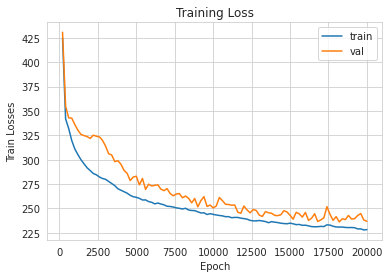

In [ ]:
plot_losses(ep_loss, ep_eval_loss, eps)

## Compute training vs validation rouge scores 

In [ ]:
pred_summaries_train, true_summaries_train = predict(model, train_data_indices)
pred_summaries_val, true_summaries_val = predict(model, val_data_indices)

In [ ]:
scores_train =  compute_rouge(pred_summaries_train, true_summaries_train)
scores_val  = compute_rouge(pred_summaries_val, true_summaries_val)

##  Rouge scores Training

In [ ]:
compute_rouge_summary_stats(scores_train)

{'rogue1_fmeasure': (0.3718518721186337,
  0.37076848476333485,
  0.3729352594739325),
 'rogue1_precision': (0.3718518721186337,
  0.37076848476333485,
  0.3729352594739325),
 'rogue1_recall': (0.3718518721186337,
  0.37076848476333485,
  0.3729352594739325),
 'rogueL_fmeasure': (0.2966015646968875,
  0.29554719614740016,
  0.2976559332463748),
 'rogueL_precision': (0.2966015646968875,
  0.29554719614740016,
  0.2976559332463748),
 'rogueL_recall': (0.2966015646968875,
  0.29554719614740016,
  0.2976559332463748)}

## Rouge Scores Validation 

In [ ]:
compute_rouge_summary_stats(scores_val)

{'rogue1_fmeasure': (0.35067994157673443,
  0.34975036299594764,
  0.3516095201575212),
 'rogue1_precision': (0.35067994157673443,
  0.34975036299594764,
  0.3516095201575212),
 'rogue1_recall': (0.35067994157673443,
  0.34975036299594764,
  0.3516095201575212),
 'rogueL_fmeasure': (0.27560593859580307,
  0.27471699543993633,
  0.2764948817516698),
 'rogueL_precision': (0.27560593859580307,
  0.27471699543993633,
  0.2764948817516698),
 'rogueL_recall': (0.27560593859580307,
  0.27471699543993633,
  0.2764948817516698)}

## Rouge Scores Histograms (Training)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


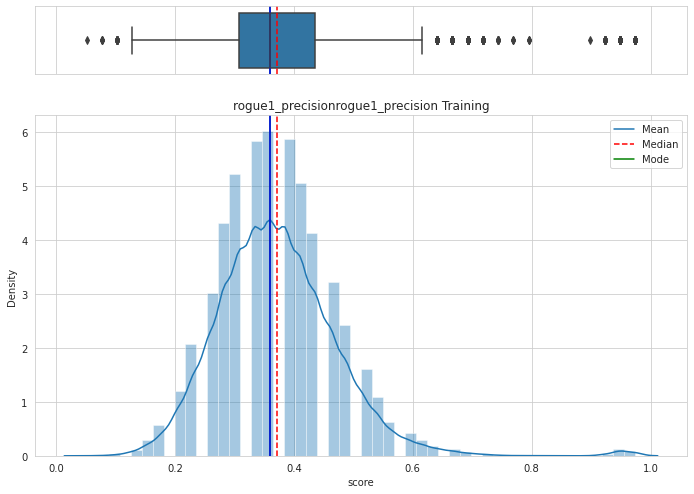

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


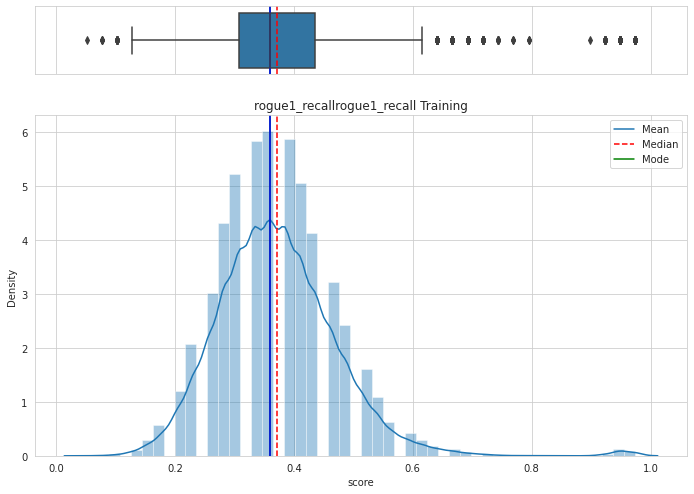

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


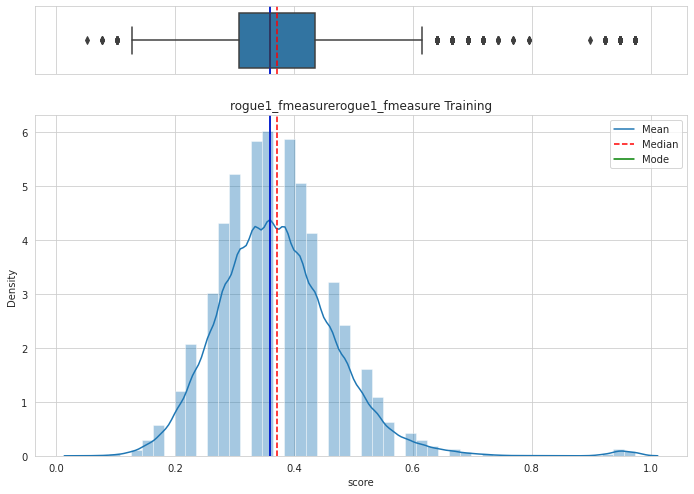

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


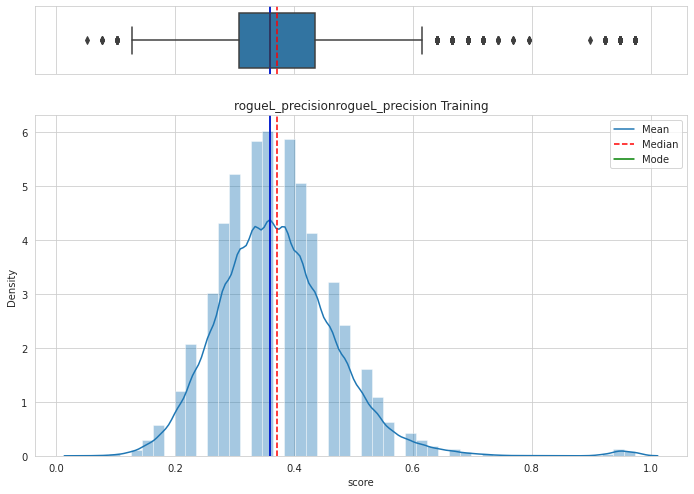

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


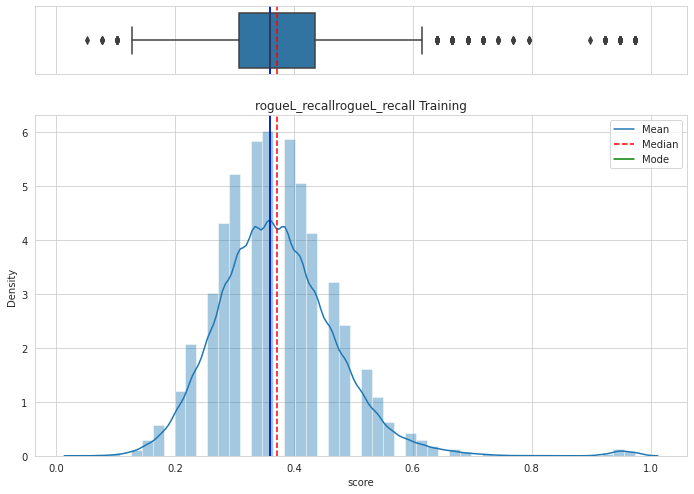

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


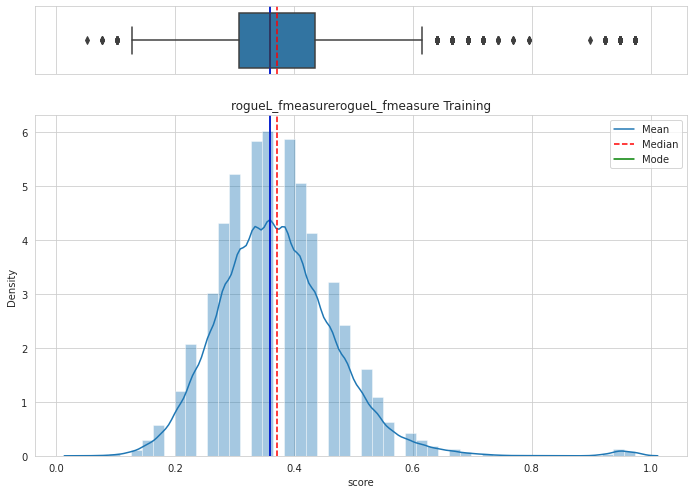

In [ ]:
plot_rogue(scores_train, 'Training')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


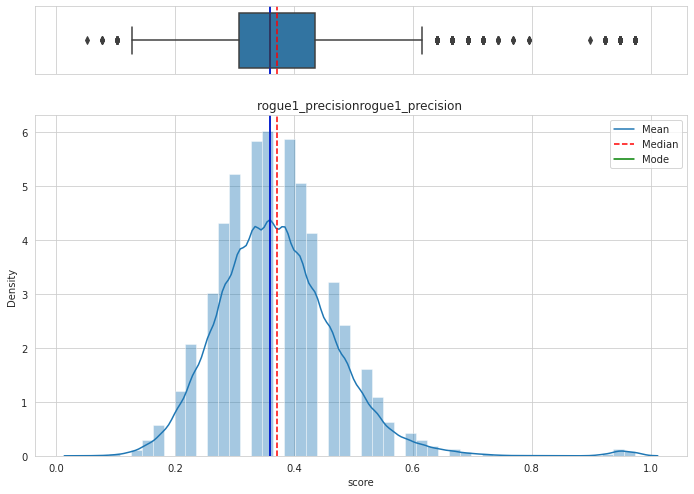

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


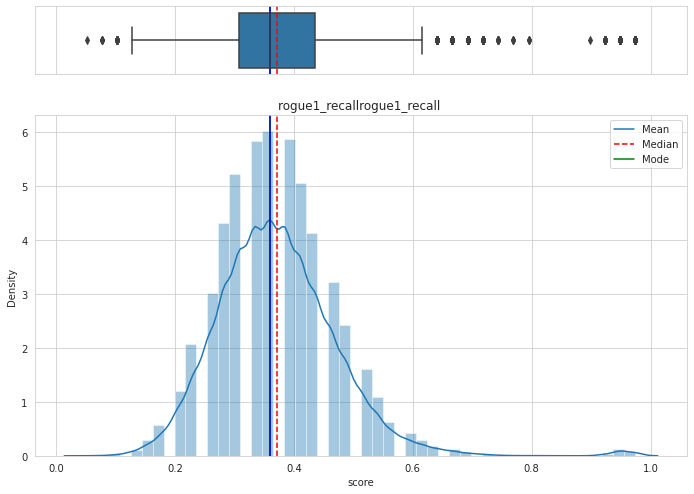

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


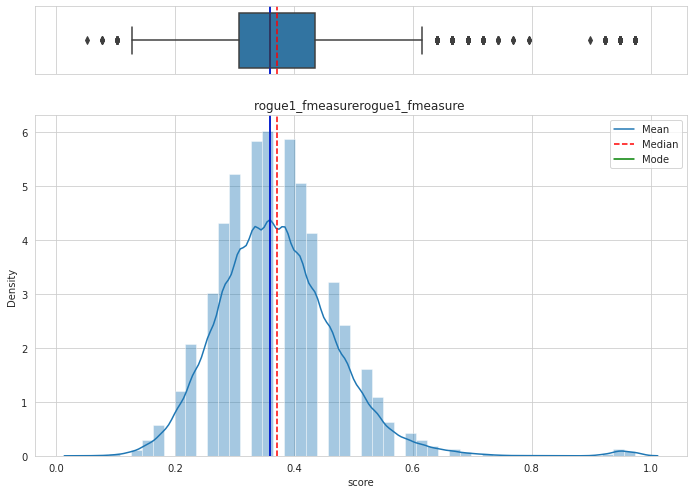

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


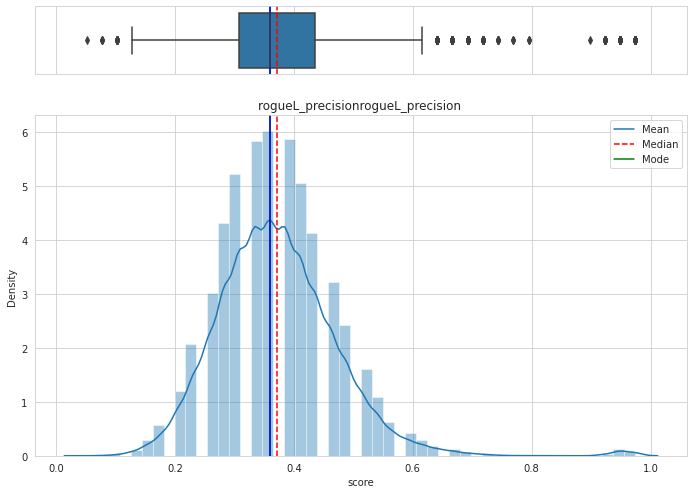

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


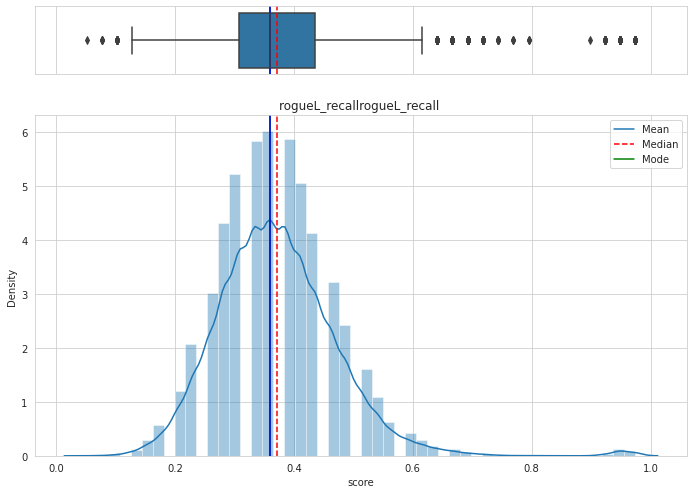

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


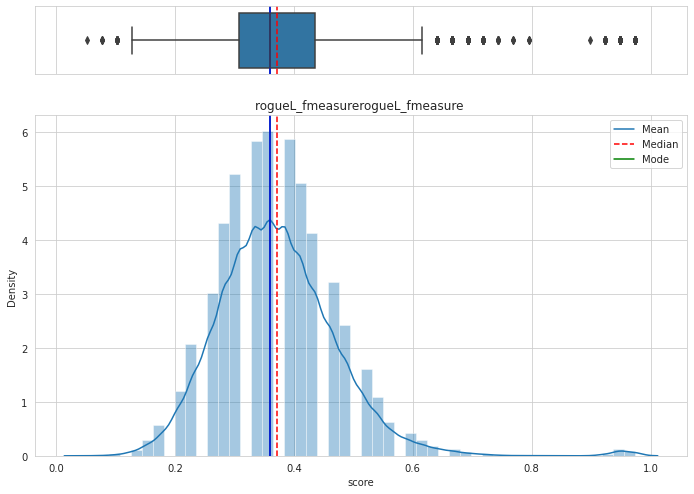

In [ ]:
plot_rogue(scores_train, '')